# LEE Analyzer Data/MC comparison plots


## Imports & Constants

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import matplotlib.patches as patches

from helpfunction import CheckBorderTPC,sciNot,sciNot2,effErr

%matplotlib inline

pd.options.display.max_columns = 999
gr      = 1.618

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
fid_min=10

# Fiducial volume borders in x,y,z:
fid_arr= [[10,10],[20,20],[10,50]]

In [2]:
catdefs={   1: 'Cosmic',
            2: 'e CC',
            3: 'mu CC',
            4: 'NC',
            5: 'Dirt',
            6: 'Data',
            7: 'Mixed',
            0: 'Other'}

pandora_pdg ={14:False,
              12:True}


def categoryPlus(row):
    label = catdefs[row['category']]
    if row['nu_pdg']==12:
        if label=='e CC':
            return r'$\nu_e$ CC   '
        elif label=='Mixed':
            return r'$\nu_e$ cont.   '
        else:
            return label+' '*(12-len( label))
    
    elif row['nu_pdg']==14:
        if label=='mu CC':
            return r'$\nu_{\mu}$ CC       '
        elif label=='Mixed':
            return r'$\nu_{\mu}$ cont.   '
        else:
            return  label+' '*(12-len( label))
        
    elif row['nu_pdg']==4294967282 or row['nu_pdg']==4294967284:
        return r'$\bar{\nu}_{\mu} / \bar{\nu}_e$          '
    elif row['nu_pdg']==15:
        return 'simulated LEE   '
    else:
        #print (row['nu_pdg'])
        return 'Cosmic intime '
    
# Formatting
def sciNotSpace(x):
    x=float(x)
    return "{:4.1f}".format(x)


#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

## Load Pickle file

In [3]:
# Used for plots: 
df_nu_test = pd.read_pickle('../Input/nu/nu39_xgb.pckl')
df_bnb     = pd.read_pickle('../Input/data/bnb_xgb.pckl')
df_bnbext  = pd.read_pickle('../Input/data/bnbext_xgb.pckl')
df_lee     = pd.read_pickle('../Input/lee/lee_xgb.pckl')
df_lee['nu_pdg']=15

#Used for training:
df_nu_train  = pd.read_pickle('../Input/nu/nu012_xgb.pckl')
df_nue_train = pd.read_pickle('../Input/nue/nue01234_xgb.pckl')
df_intime_train = pd.read_pickle('../Input/intime/intime_xgb.pckl')
df_intime_train['nu_pdg']=0

print('MC BNB nu test loaded from Pickle has '+str(len(df_nu_test.index))+' entries.' )
#print('MC BNB nu train loaded from Pickle has '+str(len(df_nu_train.index))+' entries.' )

# POT for the BNB nu test set file 3-9
pot_this = (
      1.89272433274e+20+
      1.91309713975e+20+
      1.90737421086e+20+
      1.89951666858e+20+
      1.9120295451e+20+
      1.90577422202e+20+
      1.91193765533e+20
     )
total_data_bnb_pot = 4.571e+19
total_data_pot     = 6.6e+20
lee_pot = 2.37370219e+21
scale_ext=0.117393

pot_ratio1 = pot_this/total_data_bnb_pot
pot_ratio2 = pot_this/total_data_pot



df_nu_test['catplus']=df_nu_test.apply(categoryPlus,axis=1)
df_lee['catplus']=df_lee.apply(categoryPlus,axis=1)
df_nu_train['catplus']=df_nu_train.apply(categoryPlus,axis=1)
df_nue_train['catplus']=df_nue_train.apply(categoryPlus,axis=1)
df_intime_train['catplus']=df_intime_train.apply(categoryPlus,axis=1)

df_nu_test['pandora_pdg'] = df_nu_test['candidate_pdg'].map(pandora_pdg)
df_nu_train['pandora_pdg'] = df_nu_train['candidate_pdg'].map(pandora_pdg)
df_nue_train['pandora_pdg'] = df_nue_train['candidate_pdg'].map(pandora_pdg)
df_bnb['pandora_pdg'] = df_bnb['candidate_pdg'].map(pandora_pdg)
df_bnbext['pandora_pdg'] = df_bnbext['candidate_pdg'].map(pandora_pdg)
df_lee['pandora_pdg'] = df_lee['candidate_pdg'].map(pandora_pdg)
df_intime_train['pandora_pdg'] = df_intime_train['candidate_pdg'].map(pandora_pdg)

MC BNB nu test loaded from Pickle has 223546 entries.


In [4]:
df_nu_test.head(5)

,vx,vy,vz,event,subrun,run,shower_nhits,track_nhits,candidate_pdg,numu_cuts,ccnc,qsqr,theta,bnbweight,reconstructed_energy,flash_PE,flash_time,true_vx_sce,true_vy_sce,true_vz_sce,nu_E,nu_pdg,category,distance,true_fidvol,CC_daughter_E,nu_daughters_pdg,nu_daughters_E,shower_containment_q,shower_sp_profile,shower_energy,track_energy,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,fidvol,catplus,pandora_pdg
0,240.148956,-86.596146,421.149994,372901,7459,3,"[20.0, 9.0, 0.0]","[39.0, 70.0, 120.0, 29.0]",14,0,0,0.365700,0.639702,0.986612,0.685389,710.915649,3.631250,240.218384,-86.925201,421.392548,2.007261,14,7,0.414640,True,0.419959,"[13, 111, 2212, 111, 2212, 2212, 2212]","[0.4199588456620045, 0.227973726529247, 1.0142...",0.999997,0.300000,"[0.020462613178849988, 0.01955591177985707, 0.0]","[0.07400957919836047, 0.18804490088422215, 0.2...","[0.040323373, 0.11309958]","[0.94109917, 0.026660364, 0.13857162]","[0.22299078, 0.4258124]","[0.11177769, 0.005434255, 0.06355886]","[0.031158885, 0.0016797027, 0.01584076]","[0.0039466983, 0.030223154]",True,$\nu_{\mu}$ cont.,False
1,151.847626,88.253296,670.912903,372907,7459,3,"[0.0, 10.0]","[850.0, 29.0]",14,0,0,0.315273,0.487833,0.989961,0.673907,2255.106201,4.706875,151.968658,88.889885,669.966248,1.490117,14,3,1.147169,True,0.891413,"[13, 2212, 211]","[0.8914125701604702, 1.0563318063446197, 0.332...",0.999968,0.500000,"[0.0, 0.010545739770224787]","[0.6145073126324262, 0.048853786933431315]",[0.09789748],"[0.97089887, 0.0039543556]",[0.4270087],"[0.005236099, 0.0024007896]","[0.0038262918, 0.0010482465]",[0.027838213],True,$\nu_{\mu}$ CC,False
2,96.399879,17.037233,93.984924,372910,7459,3,"[16.0, 9.0]",[515.0],14,0,0,0.155936,0.594718,0.996072,0.383421,2377.623291,4.562500,96.480774,17.094296,93.843857,0.791642,14,3,0.172338,True,0.566767,"[13, 2212, 2212]","[0.5667670032525753, 1.0214106678010686, 1.047...",0.999998,0.562500,"[0.02007475944971885, 0.013911549082712972]",[0.3494343508767468],"[0.040433437, 0.06848441]",[0.984738],"[0.18227486, 0.21018603]",[0.0018634817],[0.0012797181],"[0.011942471, 0.016079992]",True,$\nu_{\mu}$ CC,False
3,172.779556,-17.636087,438.814331,372915,7459,3,[46.0],"[856.0, 7.0]",14,0,0,0.039418,0.226269,0.994617,0.620913,1839.776123,3.248750,173.221497,-17.403925,437.848877,0.915710,14,3,1.086886,True,0.823207,"[13, 2212]","[0.8232069064700779, 0.9922255651550405]",0.999998,0.636364,[0.05665145703477925],"[0.5456004226741171, 0.01866142525813195]",[],"[0.9836624, 0.034189165]",[],"[0.012528116, 0.004207415]","[0.007044453, 0.0028686202]",[],True,$\nu_{\mu}$ CC,False
4,204.672897,50.649643,358.327728,372917,7459,3,[23.0],"[401.0, 277.0, 567.0, 484.0, 156.0, 32.0]",14,0,0,1.612378,0.945678,0.964235,1.931090,2441.779297,4.771250,204.850113,50.613113,358.190247,2.411288,14,7,0.227254,True,0.801728,"[13, 2212, 211]","[0.8017285018533991, 1.9782853698599252, 0.556...",0.999998,0.769231,[0.0315137043670039],"[0.4447239101842324, 0.41901387128051637, 0.41...",[0.12511055],"[0.99727005, 0.9972053, 0.16313986, 0.9769619,...",[0.47002333],"[0.027861066, 0.03205789, 0.002005345, 0.00218...","[0.0013286201, 0.0010006793, 0.0014515927, 0.0...",[0.00578782],True,$\nu_{\mu}$ cont.,False


## Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72893720f0>]],
      dtype=object)

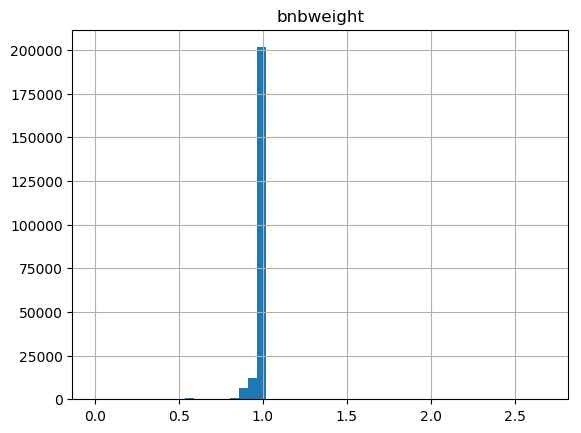

In [5]:
plt.style.use('default')
df_nu_test.hist('bnbweight',bins=50)

In [6]:
df_lee[df_lee['fidvol']==1]['catplus'].value_counts()

simulated LEE       1265
Name: catplus, dtype: int64

In [7]:
df_nu_test[df_nu_test['nu_pdg']==12].head()

,vx,vy,vz,event,subrun,run,shower_nhits,track_nhits,candidate_pdg,numu_cuts,ccnc,qsqr,theta,bnbweight,reconstructed_energy,flash_PE,flash_time,true_vx_sce,true_vy_sce,true_vz_sce,nu_E,nu_pdg,category,distance,true_fidvol,CC_daughter_E,nu_daughters_pdg,nu_daughters_E,shower_containment_q,shower_sp_profile,shower_energy,track_energy,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,fidvol,catplus,pandora_pdg
21,220.471420,-46.575756,116.088341,472469,9450,2,[22.0],"[471.0, 12.0]",14,0,0,0.753890,1.026358,0.817565,0.618609,741.767395,3.28250,48.498550,144.592606,144.224426,1.266088,12,1,258.672852,False,0.617605,"[11, 2212]","[0.6176049068681979, 0.9988655021512999]",0.999995,1.285714,[0.021638645334797518],"[0.5818823150833988, 0.015088464052987869]",[0.19068536],"[0.9988607, 0.9175278]",[0.81646085],"[0.047533754, 0.28655514]","[0.003312427, 0.07793144]",[0.01140951],True,Cosmic,False
65,218.416412,-61.008633,285.244354,31300,626,4,"[438.0, 22.0, 3.0]",[60.0],12,0,0,0.196894,0.446532,0.969553,0.744281,1069.920288,3.96125,222.440506,-65.800774,269.122345,1.052078,12,2,17.293837,True,0.954347,"[11, 2212]","[0.9543469798216804, 0.9596067741410278]",1.000000,1.876811,"[0.5685518103593775, 0.03613504793937437, 0.00...",[0.13689410623022508],"[0.88203686, 0.22856146, 0.3943618]",[0.09494883],"[0.048761655, 0.02989871, 0.04701373]",[0.52963907],[0.1495671],"[0.2749067, 0.028445177, 0.05329346]",True,$\nu_e$ CC,True
178,86.899857,-7.008054,825.151367,228205,4565,4,"[1756.0, 47.0, 30.0, 19.0]",[],12,0,0,0.217559,0.155747,1.049816,2.334776,14118.851562,3.87125,91.373489,-17.077681,848.770020,3.209983,12,2,26.062464,True,2.799711,"[11, 2212, 2212, 2212, 2212, 111, 2212]","[2.799711081528947, 0.9607074996495693, 0.9411...",0.933709,1.007005,"[2.206082465453602, 0.0664860335658904, 0.0370...",[],"[0.50534844, 0.17105392, 0.28529087, 0.18770348]",[],"[0.05152152, 0.11200201, 0.55073065, 0.26723614]",[],[],"[0.07360236, 0.010194682, 0.008418779, 0.00635...",True,$\nu_e$ CC,True
569,30.548462,94.370476,245.310867,145898,2918,4,[866.0],[],12,0,0,0.396177,0.320571,1.389756,1.340288,12337.023438,4.38125,27.940001,-63.548851,398.893799,2.159060,12,2,220.302139,True,1.800943,"[11, 211]","[1.800943458313354, 0.14862186749293527]",1.000000,10.181818,[1.340288035463623],[],[0.81758225],[],[0.053702258],[],[],[0.10893113],True,$\nu_e$ CC,True
613,76.439232,35.455196,96.728973,128150,2563,3,"[923.0, 35.0, 0.0, 9.0]",[9.0],12,0,0,0.324916,0.364502,0.959486,0.904270,12883.896484,3.81125,76.815300,35.636818,96.312508,1.784119,12,7,0.589794,True,1.385996,"[11, 2212, 111]","[1.3859958937969523, 1.052867066344865, 0.1356...",0.962262,0.830137,"[0.8282984145179054, 0.02543809944568757, 0.0,...",[0.040105086857408094],"[0.9445844, 0.3972218, 0.12667698]",[0.029384127],"[0.04587861, 0.5145286, 0.1991568]",[0.02143716],[0.015150062],"[0.9398569, 0.015110682, 0.006585063]",True,$\nu_e$ cont.,True


In [8]:
categories = ['$\\nu_e$ CC   ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.   ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC          ',
              'Cosmic      ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ',
              
              ]


catlabs = ['$\\nu_e$ CC       ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.    ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC           ',
              'Cosmic    ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$     ',]

In [9]:
# Plot of the selected events in true neutrino energy:
df=df_nu_test
entries= len(df.index)


print (categories)
true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)
    


['$\\nu_e$ CC   ', '$\\nu_{\\mu}$ CC       ', '$\\nu_e$ cont.   ', '$\\nu_{\\mu}$ cont.   ', 'NC          ', 'Cosmic      ', 'Dirt        ', '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ']


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


223546
3    87758
7    58086
1    52554
4    17718
5     5835
2     1595
Name: category, dtype: int64


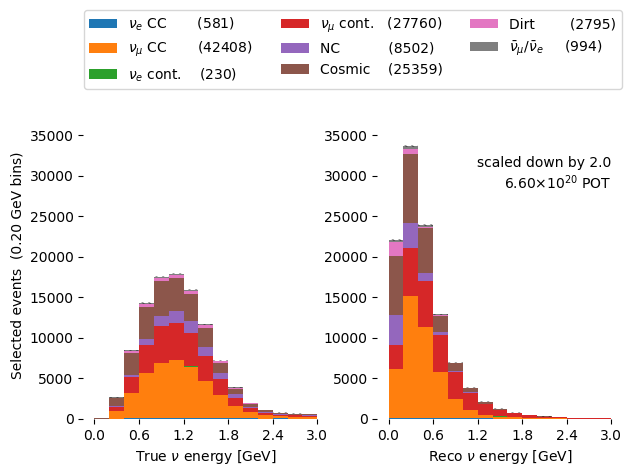

In [10]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 38000
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_before.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

In [11]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test.apply(lambda x: np.all(np.array(x['track_muon_score'])<0.13) and
                                   np.all(np.array(x['shower_muon_score'])<0.12) and
                                   (np.any(np.array(x['shower_closest_electron_score'])>0.80) or 
                                    np.any(np.array(x['track_closest_electron_score'])>0.6) ),
                                  axis=1)]

entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)
    
print(sum(bnbweight[0])/pot_ratio2)
print(sum(bnbweight[0])/sum(np.hstack(bnbweight)))

$\nu_e$ CC   
$\nu_{\mu}$ CC       
$\nu_e$ cont.   
$\nu_{\mu}$ cont.   
NC          
Cosmic      
Dirt        
$\bar{\nu}_{\mu} / \bar{\nu}_e$          
135.45328181072037
0.36212557770450865


In [12]:
print(sum(bnbweight[0])/pot_ratio2)
print(sum(bnbweight[0])/sum(np.hstack(bnbweight)))

135.45328181072037
0.36212557770450865


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


857
2    381
4    212
3    134
1     95
7     19
5     16
Name: category, dtype: int64


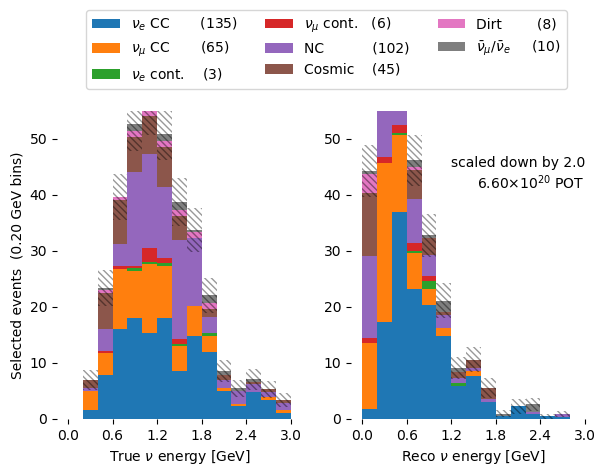

In [13]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 55
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_muanual.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

In [14]:
90/(90+21+31+4+4+2+15)

0.5389221556886228

In [15]:
df = df_nu_test[df_nu_test.apply(lambda x: np.all(np.array(x['track_muon_score'])<0.13) and
                                   np.all(np.array(x['shower_muon_score'])<0.12) and
                                   (np.any(np.array(x['shower_closest_electron_score'])>0.90) or 
                                    np.any(np.array(x['track_closest_electron_score'])>0.6) ),
                                  axis=1)]

In [16]:


print(len(df.index))
print(df['category'].value_counts())

435
2    249
4     78
1     51
3     46
7      6
5      5
Name: category, dtype: int64


In [17]:
1874/2.5*.75

562.2

# XGB $\nu_e$ score!

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from scipy.stats.mstats import gmean

In [19]:
def maxscore(arr):
    if len(arr)>0:
        return max(arr)
    else:
        return 0
    
def minscore(arr):
    if len(arr)>0:
        return min(arr)
    else:
        return 0
    
def avgscore(arr):
    if len(arr)>0:
        return gmean(arr)#sum(arr)/len(arr)
    else:
        return 0

In [20]:
def addScores(df_all):
    df_all['tr_mu_max']=df_all['track_muon_score'].apply(maxscore)
    df_all['sh_mu_max']=df_all['shower_muon_score'].apply(maxscore)

    df_all['tr_e_max_temp']=df_all['track_electron_score'].apply(maxscore)
    mean = df_all['tr_e_max_temp'][df_all['tr_e_max_temp']>0].mean()
    df_all['tr_e_max']=df_all['tr_e_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_e_max']=df_all['shower_electron_score'].apply(maxscore)

    df_all['sh_e_avg']=df_all['shower_electron_score'].apply(avgscore)

    df_all['tr_cle_max_temp']=df_all['track_closest_electron_score'].apply(maxscore)
    mean = df_all['tr_cle_max_temp'][df_all['tr_cle_max_temp']>0].mean()
    
    df_all['tr_cle_max']=df_all['tr_cle_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_cle_max']=df_all['shower_closest_electron_score'].apply(maxscore)
    df_all['sh_energy']=df_all['shower_energy'].apply(lambda x: sum(x))
    return df_all

In [29]:
df_intime_train['fidvol'].value_counts()

True    18122
Name: fidvol, dtype: int64

In [25]:
columns_train = ['tr_mu_max','sh_mu_max','tr_e_max','sh_e_max','sh_e_avg','tr_cle_max','sh_cle_max','pandora_pdg']
#columns_train = ['tr_mu_max','sh_mu_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_train = pd.concat([df_intime_train,df_nu_train,df_nue_train[df_nue_train['fidvol']==1]],ignore_index=True,copy=False)

df_train   = addScores(df_train)
df_nu_test = addScores(df_nu_test)

print(df_train.columns)
X_train = df_train[columns_train].as_matrix()
y_train = df_train['catplus']=='$\\nu_e$ CC   '
y_train_weights = df_train['bnbweight']

X_test = df_nu_test[columns_train].as_matrix()
y_test = df_nu_test['catplus']=='$\\nu_e$ CC   '
y_test_weights = df_nu_test['bnbweight']

Index(['CC_daughter_E', 'bnbweight', 'candidate_pdg', 'category', 'catplus',
       'ccnc', 'distance', 'event', 'fidvol', 'flash_PE', 'flash_time', 'nu_E',
       'nu_daughters_E', 'nu_daughters_pdg', 'nu_pdg', 'numu_cuts',
       'pandora_pdg', 'qsqr', 'reconstructed_energy', 'run',
       'shower_closest_electron_score', 'shower_containment_q',
       'shower_electron_score', 'shower_energy', 'shower_muon_score',
       'shower_nhits', 'shower_sp_profile', 'subrun', 'theta',
       'track_closest_electron_score', 'track_electron_score', 'track_energy',
       'track_muon_score', 'track_nhits', 'true_fidvol', 'true_vx_sce',
       'true_vy_sce', 'true_vz_sce', 'vx', 'vy', 'vz', 'tr_mu_max',
       'sh_mu_max', 'tr_e_max_temp', 'tr_e_max', 'sh_e_max', 'sh_e_avg',
       'tr_cle_max_temp', 'tr_cle_max', 'sh_cle_max', 'sh_energy'],
      dtype='object')


In [26]:
# fit model no training data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=y_train_weights)
print(classification_report(y_test, model.predict(X_test)))
y_pred = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_train)):
    print("%d. feature %s(%f)" % (f + 1, columns_train[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       1.00      0.95      0.98    221990
       True       0.11      0.76      0.18      1556

avg / total       0.99      0.95      0.97    223546

Feature ranking:
1. feature tr_mu_max(0.295918)
2. feature sh_mu_max(0.142857)
3. feature tr_e_max(0.116618)
4. feature sh_e_max(0.113703)
5. feature tr_cle_max(0.097668)
6. feature sh_cle_max(0.087464)
7. feature sh_e_avg(0.087464)
8. feature pandora_pdg(0.058309)


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Cut value: 0.92 keeps 23.5 % of nue CC events and 0.13 % of background events.


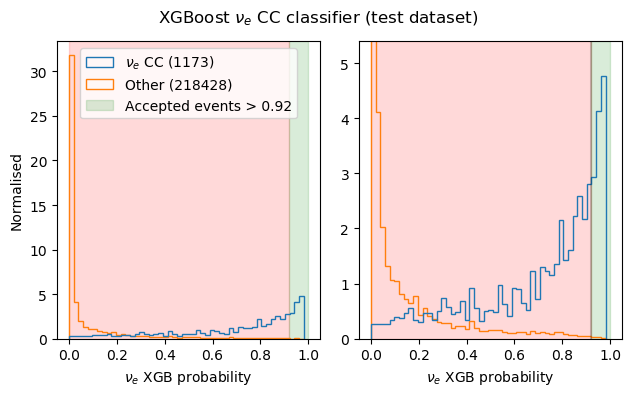

In [27]:
plt.style.use('default')
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,4),sharex=True)
plt.suptitle(r'XGBoost $\nu_e$ CC classifier (test dataset)')
N=50

nue_cut=0.92
# Electron track classification
arr_e  = y_pred[y_test==1][:,1]
arr_ne = y_pred[y_test==0][:,1]
arr_e_weigths  = y_test_weights[y_test==1]
arr_ne_weigths  = y_test_weights[y_test==0]


label_e=(r'$\nu_e$ CC ('+str(int(sum(arr_e_weigths)))+')','Other ('+str(int(sum(arr_ne_weigths)))+')')

ax[0].axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
ax[0].axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
ax[0].hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],  histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[0].set_ylabel('Normalised')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')

ax[1].axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
ax[1].axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
ax[1].hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1].set_ylim(0,5.4)
ax[1].set_xlabel(r'$\nu_e$ XGB probability')
ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

#offset=0.05
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('XGB_nue.pdf')

print('Cut value:',nue_cut,'keeps', sciNot(sum(arr_e>nue_cut) / len(arr_e)*100),'% of nue CC events and',
      sciNot2(sum(arr_ne>nue_cut) / len(arr_ne)*100),'% of background events.')

In [30]:
df_nu_test['nue_predict'] = y_pred[:,1]

In [31]:
df_nu_test['nue_predict'].mean()
nue_cut=0.92

In [32]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test['nue_predict']>nue_cut]
entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)

$\nu_e$ CC   
$\nu_{\mu}$ CC       
$\nu_e$ cont.   
$\nu_{\mu}$ cont.   
NC          
Cosmic      
Dirt        
$\bar{\nu}_{\mu} / \bar{\nu}_e$          


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 68
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.3))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_xgb.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['catplus'].value_counts())

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


653
$\nu_e$ CC                                   365
NC                                           115
$\nu_{\mu}$ CC                                78
Cosmic                                        46
$\bar{\nu}_{\mu} / \bar{\nu}_e$               16
$\nu_e$ cont.                                 11
Dirt                                          11
$\nu_{\mu}$ cont.                             11
Name: catplus, dtype: int64


In [ ]:
138/566

In [ ]:
118/(118+30+3+2+27+13+5+6)

In [ ]:
114/(114+31+4+2+33+16+5+7)

# Data Monte Carlo

In [ ]:
df_bnb   = addScores(df_bnb)
df_bnbext = addScores(df_bnbext)
df_lee = addScores(df_lee)
df_intime_train= addScores(df_intime_train)

df_bnb['nue_predict']    = model.predict_proba(df_bnb[columns_train].as_matrix())[:,1]
df_bnbext['nue_predict'] = model.predict_proba(df_bnbext[columns_train].as_matrix())[:,1]
df_lee['nue_predict'] = model.predict_proba(df_lee[columns_train].as_matrix())[:,1]
df_intime_train['nue_predict'] = model.predict_proba(df_intime_train[columns_train].as_matrix())[:,1]

In [ ]:
sum(df_lee['nue_predict']>nue_cut)*total_data_bnb_pot/lee_pot
df_lee['nu_E'].hist()

In [ ]:
# For MC
#['tr_mu_max','sh_mu_max','tr_e_max','sh_e_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_before = df_nu_test
df_after  = df_nu_test[df_nu_test['nue_predict']>nue_cut]

nue_score_before = []
tr_mumax_score_before = []
reco_E_before = [] 
labels_before = []
bnbweight_before =[]

reco_E_after = [] 
labels_after = []
bnbweight_after =[]

catlabs = ['$\\nu_e$ CC      ',
              '$\\nu_{\\mu}$ CC        ',
              '$\\nu_e$ cont.     ',
              '$\\nu_{\\mu}$ cont.    ',
              'NC            ',
              'Cosmic    ',
              'Dirt         ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$       ']

for cat,catlab in zip(categories,catlabs):
    nue_score_before.append(df_before[df_before['catplus']==cat]['nue_predict'])
    tr_mumax_score_before.append(df_before[df_before['catplus']==cat]['tr_cle_max_temp'])
    
    reco_E_before.append(df_before[df_before['catplus']==cat]['reconstructed_energy'])
    reco_E_after.append(df_after[df_after['catplus']==cat]['reconstructed_energy'])
    
    bnbweight_before.append(df_before[df_before['catplus']==cat]['bnbweight']) 
    bnbweight_after.append(df_after[df_after['catplus']==cat]['bnbweight'])

    lab = catlab+ '('+str(     int(round(sum(bnbweight_after[-1])/pot_ratio1))) +')'
    labels_before.append(lab)
    lab = catlab+ '('+sciNot(sum(bnbweight_after[-1])/pot_ratio1) +')'
    labels_after.append(lab)
    
print([len(x)/pot_ratio1 for x in reco_E_before])
print([len(x)/pot_ratio1 for x in reco_E_after])

In [ ]:
# for DATA

df_data = [df_bnb,df_bnbext]

data_nue_score_before = []
data_tr_mumax_score_before = []

data_reco_E_before    = [] 
data_reco_E_after     = [] 


for index,df in enumerate(df_data):
    
    df_before = df
    df_after = df[df['nue_predict']>nue_cut]

    data_nue_score_before.append(df_before['nue_predict'])
    data_tr_mumax_score_before.append(df_before['tr_cle_max_temp'])
    
    data_reco_E_before.append(df_before['reconstructed_energy'])
    data_reco_E_after.append(df_after['reconstructed_energy'])
    
print([len(x) for x in data_reco_E_before])
print([len(x) for x in data_reco_E_after])

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 15
min_x = 0.0
max_x = 3.
step  = 0.6
y_max1 = 7000
y_max2 = 10.5
binwidth=(max_x-min_x)/N


lower,edges,_ = ax[0].hist(np.array(data_reco_E_before[1]),weights=[scale_ext]*len(data_reco_E_before[1]) ,bins=N, range=(min_x,max_x), fill=True,histtype='step',alpha = 0.2, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(labels_after,reco_E_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8)
    lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_reco_E_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+0.1, bins, xerr=0.1, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(3,5000, 'Data: '+str(len(data_reco_E_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events",horizontalalignment='right')
    
    
    
lower,edges,_= ax[1].hist(np.array(data_reco_E_after[1]),weights=[scale_ext]*len(data_reco_E_after[1]),bins=N, range=(min_x,max_x), fill=True,histtype='step',label='BNB ext    '+ '('+sciNot(len(data_reco_E_after[1])*scale_ext) +')',alpha = 0.2, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(labels_after,reco_E_after,bnbweight_after):
    lower_this,_,_ = ax[1].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,label=lab,bottom=lower,alpha=0.8)
    lower+=lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_after)), list(chain.from_iterable(bnbweight_after)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
bins,edges = np.histogram(data_reco_E_after[0],N, range=(min_x,max_x))
ax[1].errorbar(edges[:9]+0.1, bins[:9], xerr=0.1, yerr=np.sqrt(bins[:9]),alpha=0.8, color= 'k',fmt='.')

print(bins)

ax[0].set_ylabel('#Events ('+sciNot2(binwidth)+' GeV bins )')
ax[0].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.32))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,y_max2*.66, 'Data: '+str(len(data_reco_E_after[0]))+' events'+"\nMC+BNB ext: "+sciNot(sum(lower))+" events\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')


plt.savefig("data_mc.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.8
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,200, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     
print(bins/lower)   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("data_mc_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.
binwidth=(max_x-min_x)/N


lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,200, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     

nu_e_CC,_ = np.histogram(nue_score_before[0],N,weights=bnbweight_before[0], range=(min_x,max_x))
mc_total  = lower*pot_ratio1
cum_nue = np.cumsum(nu_e_CC[::-1])[::-1] 
cum_tot = np.cumsum(mc_total[::-1])[::-1] 
cum_nue_eff=cum_nue/cum_nue[0]

ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))
ax[1].errorbar(edges[:-1], cum_nue_eff, xerr=binwidth/2, yerr=effErr(cum_nue,cum_nue[0]),alpha=1.0, fmt='.',label='Efficiency  (23.5%)')
ax[1].errorbar(edges[:-1], cum_nue/cum_tot, xerr=binwidth/2, yerr=effErr(cum_nue,cum_tot),alpha=1.0, fmt='.',label='Purity      (40%)')
ax[1].legend(loc='upper left',bbox_to_anchor=(0.3, 1.1))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("eff_pur_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)



In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.5
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,tr_mumax_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_tr_mumax_score_before[1]),weights=[scale_ext]*len(data_tr_mumax_score_before[1]) ,bins=N, range=(min_x,max_x),bottom=lower,stacked=False, fill=True,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(tr_mumax_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_tr_mumax_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
#ax[0].text(0.7,2000, 'Data: '+str(len(data_tr_mumax_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     
print(bins/lower)   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'maximum $e$-shower probability')
ax[0].set_ylim(0.1,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'maximum $e$-shower probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("data_mc_sh_emax.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

# BNB nue intrinsic plots:

In [ ]:
# Used for plots: 
df_nue_test       = pd.read_pickle('../Input/nue/nue56789_xgb.pckl')
df_nue_nonpassed  = pd.read_pickle('../Input/nue/nue_nonpassed.pckl')

print('Passed: ',len(df_nue_test.index),'+',len(df_nue_train.index),' entries.')
print('Not-passed: ',len(df_nue_nonpassed.index),' entries.')

df_nue_test['fidvol'].value_counts()

In [ ]:
df_nue_passed = pd.concat([df_nue_train,df_nue_test],ignore_index=True,copy=False)
#df_nue_passed = df_nue_test
print('Passed: ',len(df_nue_passed.index),' entries.')
print('Not-passed: ',len(df_nue_nonpassed.index),' entries.')

df_nue_selected = addScores(df_nue_passed[df_nue_passed['fidvol']==True])

df_nue_selected['nue_predict']    = model.predict_proba(df_nue_selected[columns_train].as_matrix())[:,1]

print('weighted total :',str(sum(df_nue_passed['bnbweight'])+sum(df_nue_nonpassed['bnbweight']) ))
print('has shower and optical cuts:',str(sum(df_nue_passed['bnbweight'])))
print('in fiducial volume:',str(sum(df_nue_selected['bnbweight'])))
print('final selection :',str(sum(df_nue_selected[(df_nue_selected['nue_predict']>nue_cut) ]['bnbweight'])))
print('final selection pure :',str(sum(df_nue_selected[(df_nue_selected['nue_predict']>0) & (df_nue_selected['category']==2) ]['bnbweight'])))

In [ ]:
df_nue_selected.columns

In [ ]:
total_denom = sum(df_nue_passed['bnbweight'])+sum(df_nue_nonpassed['bnbweight']) 
true_E_denom = np.append( df_nue_nonpassed['nu_E'].values ,  df_nue_passed['nu_E'].values)
weight_denom = np.append( df_nue_nonpassed['bnbweight'].values ,  df_nue_passed['bnbweight'].values)

total_nom_3 = sum(df_nue_selected[(df_nue_selected['nue_predict']>nue_cut)]['bnbweight'])
true_E_nom_3 = df_nue_selected[(df_nue_selected['nue_predict']>nue_cut) ]['nu_E'].values
weight_nom_3 = df_nue_selected[df_nue_selected['nue_predict']>nue_cut]['bnbweight'].values

total_nom_2 = sum(df_nue_selected[(df_nue_selected['nue_predict']>0)& (df_nue_selected['category']==2)]['bnbweight'])
true_E_nom_2 = df_nue_selected[(df_nue_selected['nue_predict']>0)   & (df_nue_selected['category']==2)]['nu_E'].values
weight_nom_2 = df_nue_selected[(df_nue_selected['nue_predict']>0)   & (df_nue_selected['category']==2)]['bnbweight'].values

total_nom_1 = sum(df_nue_selected[(df_nue_selected['nue_predict']>0)]['bnbweight'])
true_E_nom_1 = df_nue_selected[(df_nue_selected['nue_predict']>0)   ]['nu_E'].values
weight_nom_1 = df_nue_selected[(df_nue_selected['nue_predict']>0)   ]['bnbweight'].values

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 35
min_x = 0.0
max_x = 3.5
binwidth=(max_x-min_x)/N
step=0.6

denom, edges = np.histogram(true_E_denom,bins=N,range=(min_x,max_x),weights=weight_denom)
nom1, _       = np.histogram(true_E_nom_1,bins=N,range=(min_x,max_x),weights=weight_nom_1)
nom2, _       = np.histogram(true_E_nom_2,bins=N,range=(min_x,max_x),weights=weight_nom_2)
nom3, _       = np.histogram(true_E_nom_3,bins=N,range=(min_x,max_x),weights=weight_nom_3)

eff1 = nom1/denom
eff2 = nom2/denom
eff3 = nom3/denom

ax[0].errorbar(edges[:-1]+0.05, eff1 , xerr=0.05, yerr=effErr(nom1,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{selected}$ ('+sciNot(sum(weight_nom_1)/sum(weight_denom)*100)+'%)')
ax[0].errorbar(edges[:-1]+0.05, eff2 , xerr=0.05, yerr=effErr(nom2,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{selected+category}$ ('+sciNot(sum(weight_nom_2)/sum(weight_denom)*100)+'%)')
ax[0].errorbar(edges[:-1]+0.05, eff3 , xerr=0.05, yerr=effErr(nom3,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{final}$ ('+sciNot(sum(weight_nom_3)/sum(weight_denom)*100)+'%)')

ax[1].hist(true_E_denom,weights= weight_denom, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True,color='k',lw=3,alpha=0.3,label=r'BNB $\nu_e$ spectrum')
ax[1].hist(true_E_nom_1,weights= weight_nom_1, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True)
ax[1].hist(true_E_nom_2,weights= weight_nom_2, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True)
ax[1].hist(true_E_nom_3,bins=edges[:-1],weights= weight_nom_3,histtype='step',fill=False,stacked='False',density=True,lw=3,alpha=0.5,label=r'Final $\nu_e$ selection')

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

ax[0].set_ylabel('Efficiency ('+sciNot2(binwidth)+' GeV bins)')
ax[1].set_ylabel('Area normalised ('+sciNot2(binwidth)+' GeV bins)')

ax[0].set_xlim(min_x,max_x)
ax[1].set_xlim(min_x,3.5)

ax[0].set_ylim(0,1.)

ax[0].set_xlabel(r'True $\nu_e$ energy [GeV]')
ax[1].set_xlabel(r'True $\nu_e$ energy [GeV]')

ax[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.2))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.5, 1.2))

plt.tight_layout(w_pad=3.)
plt.savefig("eff.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

In [ ]:
df_nue_selected['tr_cle_max'].hist(range=[0.5,1])
len(df_nue_selected)*0.025
8*150

In [ ]:
sum(df_nue_selected['nue_predict']>nue_cut)

In [ ]:
g = sns.JointGrid(x="nu_E", y="nue_predict",data=df_nue_selected.head(5000),xlim=(0,3.5),ylim=(0.0,1.0))
g.plot_joint(sns.kdeplot,shade=True,cmap="Blues") 
g.plot_marginals(sns.distplot,bins=40)

In [ ]:
g = sns.JointGrid(x="bnbweight", y="nu_E",data=df_nue_selected.head(5000),xlim=(0.3,1.5),ylim=(0.0,5.0))
g.plot_joint(sns.kdeplot,shade=True,cmap="Blues") 
g.plot_marginals(sns.distplot,bins=40)

In [ ]:
pot_this = (
      1.89272433274e+20+
      1.91309713975e+20+
      1.90737421086e+20+
      1.89951666858e+20+
      1.9120295451e+20+
      1.90577422202e+20+
      1.91193765533e+20
     )
total_events_nu = 1888600
total_events_intime = 956046
total_pot_nu = 1.90601703789e+21
total_data_bnb_pot = 4.571e+19
intime_scaling = 10.279*(total_events_nu/total_events_intime)*(total_data_bnb_pot/total_pot_nu)

In [ ]:
#Cosmic intime scaling:
intime_scaling

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(9.5,4),sharey=False,sharex=False)
nr_ext = str(int(len(df_bnbext.index)*scale_ext))
nr_intime = str(int(len(df_intime_train.index)*intime_scaling))

err_bnbext = np.sqrt(lower/scale_ext)*scale_ext

ax[2].hist(df_bnbext['nue_predict'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,1),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[2].hist(df_intime_train['nue_predict'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,1),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[2].set_xlabel(r'$\nu_e$ XGB probability')
ax[2].set_yscale("log", nonposy='clip')
ax[2].set_title(r'$\nu_e$ CC inclusive classifier')

ax[0].hist(df_bnbext['flash_PE'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,10000),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[0].hist(df_intime_train['flash_PE'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,10000),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[0].set_xlabel('Photon-electrons')
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_title('Photo-electrons in Flash')

ax[1].hist(df_bnbext['reconstructed_energy'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,2),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[1].hist(df_intime_train['reconstructed_energy'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,2),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[1].set_xlabel('E [GeV]')
ax[1].set_yscale("log", nonposy='clip')
ax[1].set_title('Reconstructed energy')

ax[0].set_ylabel('Events per bin')
ax[0].text(9999,200, "Scaled to "+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT'+"\n\n"+
           'Data: '+nr_ext+' events'+"\nMC: "+nr_intime+' events'
           ,horizontalalignment='right')
plt.legend()

plt.tight_layout(w_pad=1.)
plt.savefig("intime.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)